In [1]:
import faulthandler
from matplotlib import pyplot as plt
import numpy as np
import os

from pynpoint import Pypeline, FitsReadingModule, PSFpreparationModule, \
    PcaPsfSubtractionModule, FalsePositiveModule, SimplexMinimizationModule, \
    FakePlanetModule, ContrastCurveModule, FitsWritingModule
    
from pynpoint.readwrite.attr_reading import ParangReadingModule

import redux_utils

faulthandler.enable()

/home/asatk/PynPoint/pynpoint/util/wavelets.py:18: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(cache=True)
/home/asatk/PynPoint/pynpoint/util/apply_func.py:591: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(cache=True)
/home/asatk/PynPoint/pynpoint/util/apply_func.py:761: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to th

In [2]:
firstchannelnum = 45
lastchannelnum = 74
channelnums = list(range(firstchannelnum, lastchannelnum))
nchnls = len(channelnums)

data_dir = "data"
data_path = data_dir + "/" + "005_center_multishift/wl_channel_%05i.fits"
data_paths = [data_path%(channelnum) for channelnum in channelnums]

out_dir = "out"
outcombined_path = "out/pyn_PCA%03i_%05i_%05i.fits"%(redux_utils.numcomps, firstchannelnum, lastchannelnum)

working_dir = "pyn"
working_path = "pyn/PynPoint_database.hdf5"

tempanglesname = "tempangles.txt"
# tempangles = np.array([redux_utils.angles] * nchnls).flatten()
# with open(data_dir + "/" + tempanglesname, "w") as anglesfile:
#     anglesfile.write('\n'.join(str(i) for i in tempangles))

In [3]:
# sep_tuple = (0., 0.8, 0.05)
# angle_tuple = (0.0, 360.0, 72.0)
sep_tuple = (0., 0.8, 0.4)
angle_tuple = (0.0, 360.0, 180.0)

nchnls = len(data_paths)
# pca_nums = list(range(1, redux_utils.numcomps + 1))
# pca_num = redux_utils.numcomps
# pca_nums = [1, 5, 9]
pca_nums = [5]
pca_num = 5

mask_inner = 0.2
mask_outer = 0.35

posn_planet = (12, 41)
dmag_planet = 6.35

# figure out which apt corresponds to what
pixscale = 0.027
apt_pl = 5 * pixscale
apt_psf = 10 * pixscale
apt_cc = 0.2


tolerance = 0.1
offset = 0.1

In [4]:
pipeline = Pypeline(working_place_in=working_dir,
                input_place_in=data_dir,
                output_place_in=out_dir)
module_read = FitsReadingModule(name_in="read",
                filenames=data_paths,
                image_tag='imgs')
module_parang = ParangReadingModule(name_in="angs",
                data_tag='imgs',
                file_name=tempanglesname,
                overwrite=True)
module_prep = PSFpreparationModule(name_in='prep',
                image_in_tag='imgs',
                image_out_tag='masked',
                mask_out_tag=None,
                norm=False,
                resize=None,
                cent_size=mask_inner,
                edge_size=None)
module_psf = PSFpreparationModule(name_in='prep2',
                image_in_tag='imgs',
                image_out_tag='psf',
                mask_out_tag=None,
                norm=False,
                resize=None,
                cent_size=None,
                edge_size=mask_outer)
module_pcasub = PcaPsfSubtractionModule(name_in='pca',
                pca_numbers=pca_nums,
                images_in_tag='masked',
                reference_in_tag='masked',
                res_mean_tag='pca_mean',
                res_median_tag='pca_median',
                basis_out_tag='pca_basis',
                subtract_mean=True,
                processing_type='ADI')
module_fp = FalsePositiveModule(name_in='fp',
                image_in_tag='pca_median',
                snr_out_tag='snr',
                position=posn_planet,
                aperture=5*0.027,
                ignore=True,
                optimize=True,
                offset=offset)
module_simplex = SimplexMinimizationModule(name_in="simplex",
                image_in_tag="imgs",
                psf_in_tag="psf",
                res_out_tag="simplex_res",
                flux_position_tag="fluxpos",
                position=posn_planet,
                magnitude=dmag_planet,
                psf_scaling=-1.,
                merit="gaussian",
                aperture=10*0.027,
                sigma=0.,
                tolerance=tolerance,
                pca_number=pca_nums,
                cent_size=mask_inner,
                edge_size=None,
                residuals="median",
                reference_in_tag=None,
                offset=offset)
module_fakeplanet = FakePlanetModule(name_in="fake",
                image_in_tag="masked",
                psf_in_tag="psf",
                image_out_tag="removed",
                position=posn_planet,
                magnitude=dmag_planet,
                psf_scaling=-1.0,
                interpolation="spline")
module_ccurve = ContrastCurveModule(name_in="ccurve",
                image_in_tag="removed",
                psf_in_tag="psf",
                contrast_out_tag="limits",
                separation=sep_tuple,
                angle=angle_tuple,
                # threshold=("sigma", 5.0),
                threshold=('fpf', 2.87e-7),
                psf_scaling=1.,
                aperture=0.2,
                pca_number=pca_num,
                cent_size=mask_inner,
                edge_size=None,
                residuals="median",
                snr_inject=100.)
module_write1 = FitsWritingModule(name_in='write1',
                data_tag='pca_median',
                file_name='pyn_pca_median.fits',
                data_range=None,
                overwrite=True,
                subset_size=None)
module_write2 = FitsWritingModule(name_in='write2',
                data_tag='pca_mean',
                file_name='pyn_pca_mean.fits',
                data_range=None,
                overwrite=True,
                subset_size=None)

pipeline.add_module(module_read)
pipeline.add_module(module_parang)
pipeline.add_module(module_prep)
pipeline.add_module(module_pcasub)
pipeline.add_module(module_psf)
pipeline.add_module(module_fp)
pipeline.add_module(module_simplex)
pipeline.add_module(module_fakeplanet)
pipeline.add_module(module_ccurve)
pipeline.add_module(module_write1)
pipeline.add_module(module_write2)

PynPoint v0.10.0

Working place: pyn
Input place: data
Output place: out

Database: pyn/PynPoint_database.hdf5
Configuration: pyn/PynPoint_config.ini

Number of CPUs: 1
Number of threads: not set


In [5]:
pipeline.run_module('read')


-----------------
FitsReadingModule
-----------------

Module name: read


/home/asatk/PynPoint/pynpoint/util/attributes.py:76: UserWarning: Static attribute INSTRUMENT (=INSTRUME) not found in the FITS header.
  warnings.warn(f'Static attribute {attr} (={fitskey}) not found in the FITS '
/home/asatk/PynPoint/pynpoint/util/attributes.py:76: UserWarning: Static attribute DIT (=ESO DET DIT) not found in the FITS header.
  warnings.warn(f'Static attribute {attr} (={fitskey}) not found in the FITS '
/home/asatk/PynPoint/pynpoint/util/attributes.py:76: UserWarning: Static attribute LATITUDE (=ESO TEL GEOLAT) not found in the FITS header.
  warnings.warn(f'Static attribute {attr} (={fitskey}) not found in the FITS '
/home/asatk/PynPoint/pynpoint/util/attributes.py:76: UserWarning: Static attribute LONGITUDE (=ESO TEL GEOLON) not found in the FITS header.
  warnings.warn(f'Static attribute {attr} (={fitskey}) not found in the FITS '
/home/asatk/PynPoint/pynpoint/util/attributes.py:125: UserWarning: Non-static attribute EXP_NO (=ESO DET EXP NO) not found in the FITS 

Reading FITS files... [DONE]                      
Output ports: imgs (63858, 63, 63), fits_header/wl_channel_00045.fits (7,), fits_header/wl_channel_00046.fits (7,), fits_header/wl_channel_00047.fits (7,), fits_header/wl_channel_00048.fits (7,), fits_header/wl_channel_00049.fits (7,), fits_header/wl_channel_00050.fits (7,), fits_header/wl_channel_00051.fits (7,), fits_header/wl_channel_00052.fits (7,), fits_header/wl_channel_00053.fits (7,), fits_header/wl_channel_00054.fits (7,), fits_header/wl_channel_00055.fits (7,), fits_header/wl_channel_00056.fits (7,), fits_header/wl_channel_00057.fits (7,), fits_header/wl_channel_00058.fits (7,), fits_header/wl_channel_00059.fits (7,), fits_header/wl_channel_00060.fits (7,), fits_header/wl_channel_00061.fits (7,), fits_header/wl_channel_00062.fits (7,), fits_header/wl_channel_00063.fits (7,), fits_header/wl_channel_00064.fits (7,), fits_header/wl_channel_00065.fits (7,), fits_header/wl_channel_00066.fits (7,), fits_header/wl_channel_00067.fits

In [6]:
pipeline.run_module('angs')


-------------------
ParangReadingModule
-------------------

Module name: angs
Reading parallactic angles... [DONE]
Number of angles: 63858
Rotation range: -54.50 -> 55.19 deg
Output port: imgs (63858, 63, 63)


In [7]:
pipeline.run_module('prep')


--------------------
PSFpreparationModule
--------------------

Module name: prep
Input port: imgs (63858, 63, 63)
Deleting data and attributes: masked
Preparing images for PSF subtraction... [DONE]                      
Output port: masked (63858, 63, 63)


In [8]:
pipeline.run_module('prep2')


--------------------
PSFpreparationModule
--------------------

Module name: prep2
Input port: imgs (63858, 63, 63)
Deleting data and attributes: psf
Preparing images for PSF subtraction... [DONE]                      
Output port: psf (63858, 63, 63)


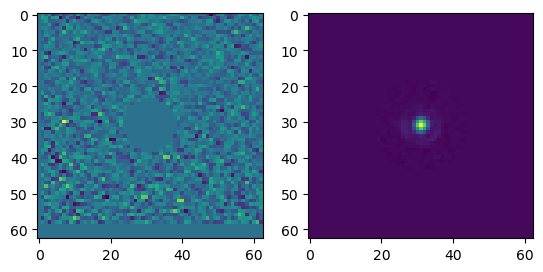

In [9]:
fig, ax = plt.subplots(1, 2)

masked_psf = pipeline.get_data("masked")
psf = pipeline.get_data("psf")
ax[0].imshow(masked_psf[10, ])
ax[1].imshow(psf[10, ])

In [10]:
pipeline.run_module('pca')


-----------------------
PcaPsfSubtractionModule
-----------------------

Module name: pca
Input port: masked (63858, 63, 63)
Deleting data and attributes: pca_mean
Deleting data and attributes: pca_median
Deleting data and attributes: pca_basis
Input parameters:
   - Post-processing type: ADI
   - Number of principal components: [5]
   - Subtract mean: True
   - Extra rotation (deg): 0.0
Constructing PSF model... [DONE]
Creating residuals... [DONE]                      
Output ports: pca_mean (1, 63, 63), pca_median (1, 63, 63), pca_basis (5, 63, 63)


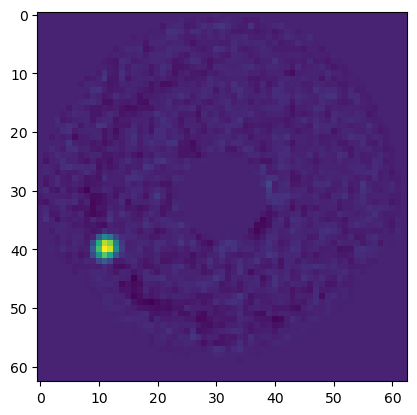

In [11]:
residuals = pipeline.get_data('pca_median')
plt.imshow(residuals[0, ])

In [12]:
pipeline.run_module('fp')


-------------------
FalsePositiveModule
-------------------

Module name: fp
Input port: pca_median (1, 63, 63)
Deleting data and attributes: snr
Input parameters:
   - Aperture position = (12, 41)
   - Aperture radius (pixels) = 5.00
   - Optimize aperture position = True
   - Ignore neighboring apertures = True
   - Minimization tolerance = 0.01
Calculating the S/N and FPF...
Image 001/1 -> (x, y) = (12.05, 40.92), S/N = 17.10, FPF = 1.80e-08
Output port: snr (1, 6)


In [13]:
pipeline.run_module('simplex')


-------------------------
SimplexMinimizationModule
-------------------------

Module name: simplex
Input ports: imgs (63858, 63, 63), psf (63858, 63, 63)
Deleting data and attributes: simplex_res005
Deleting data and attributes: fluxpos005
Input parameters:
   - Number of principal components = [5]
   - Figure of merit = gaussian
   - Residuals type = median
   - Absolute tolerance (pixels/mag) = 0.1
   - Maximum offset = 0.1
   - Guessed position (x, y) = (12.00, 41.00)
   - Aperture position (x, y) = (12, 41)
   - Aperture radius (pixels) = 10
   - Inner mask radius (pixels) = 7
Image center (y, x) = (31.0, 31.0)
Simplex minimization... 5 PC - chi^2 = 7.46e+03

: 

: 

In [ ]:
pipeline.run_module('fake')

In [ ]:
pipeline.run_module('ccurve')

In [ ]:
pipeline.run_module('write1')

In [ ]:
pipeline.run_module('write2')

In [ ]:
residuals = pipeline.get_data('pca_median')
pixscale = pipeline.get_attribute('pca_median', 'PIXSCALE')
size = pixscale * residuals.shape[-1]/2

In [ ]:
plt.imshow(residuals[0, ], origin='lower', extent=[size, -size, -size, size])
plt.xlabel('RA offset (arcsec)', fontsize=14)
plt.ylabel('Dec offset (arcsec)', fontsize=14)
cb = plt.colorbar()
cb.set_label('Flux (ADU)', size=14.)